In [20]:
# Notebook configuration
RESULTS_DIR = "./results/two/"
GT_DIR = "/mnt/nas1/fvs_benchmark_datasets"

In [2]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib widget
%matplotlib inline
import ipywidgets as widgets

In [21]:
# Load CSV
pgvector_csvs = []

for file in os.listdir(RESULTS_DIR):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(RESULTS_DIR, file)
        pgvector_csvs.append(fpath)
           
if len(pgvector_csvs)==0:
    raise Exception("No CSVs found in pgvector!")
print("found %d CSV files for pgvector" % len(pgvector_csvs))



pgvector_deep-10K_64_32.csv
pgvector_deep-1M_64_32.csv
pgvector_deep-1M_64_32_20.csv
pgvector_deep-1M_64_32_50.csv
pgvector_deep-1M_64_32_100.csv
found 5 CSV files for pgvector


In [22]:
# Load to df
pgvector_dfs = []

for csv in pgvector_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    pgvector_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
pgvector_df = pd.concat( pgvector_dfs )
print("There are %d rows" % pgvector_df.shape[0])



Concatenating into one master dataframe...
There are 20005 rows


## GT

In [5]:
def size_num(s):
    '''get raw numercs of text abbrev'''
    if s == '1M': return 1000000
    elif s == '2M': return 2000000
    elif s == '5M': return 5000000
    elif s == '10M': return 10000000
    elif s == '20M': return 20000000
    elif s == '50M': return 50000000
    elif s == '100M': return 100000000
    elif s == '200M': return 200000000
    elif s == '250M': return 250000000
    elif s == '500M': return 500000000
    elif s == '10K': return 10000
    elif s == '1000M': return 1000000000
    else: raise Exception("Unsupported size " + s)
    
def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    elif numrecs==1000000000: return "1000M"
    else: raise Exception("Unsupported size" + str(numrecs))
    
def compute_recall(a, b):
    '''Computes the recall metric on query results.'''

    nq, rank = a.shape
    intersect = [ np.intersect1d(a[i, :rank], b[i, :rank]).size for i in range(nq) ]
    ninter = sum( intersect )
    return ninter / a.size, intersect

In [17]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in pgvector_df['numrecs'].unique():
    if numrecs == -1:
        continue
    
    ef_unique = pgvector_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = pgvector_df[(pgvector_df['ef_search']== ef_search) & (pgvector_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
result_df = pd.DataFrame(dic)
        


10K 64 1000 0.9994000000000001 0.826513
10K 128 1000 1.0 1.733033
10K 256 1000 1.0 3.0198320000000005
10K 512 1000 1.0 5.500468000000001
10M 64 1000 0.9602 13.198215
10M 128 1000 0.9814 22.090387000000003
10M 256 1000 0.9906 39.037069
10M 512 1000 0.9953 67.993154
1M 64 1000 0.9827 11.472851
1M 128 1000 0.993 18.731753
1M 256 1000 0.997 31.812690000000003
1M 512 1000 0.9991 53.688832
5M 64 1000 0.9645000000000001 14.683648
5M 128 1000 0.9863 24.864699
5M 256 1000 0.9940999999999999 43.000437000000005
5M 512 1000 0.9970999999999999 73.910151


In [7]:
# p90/95/99 latency, show not just mean, capture in a csv
# error bar along y axis, range, interval, stats interval, boxplots intervals, coretile analysis for recall

In [8]:
def plot_paretto(num_records):

    df = result_df[ result_df['numrecs'] == num_records]
    print(df)

    # extract the lines for plotting
    paretto_parameters = list(df['ef_search'])
    paretto_search = list(df['latency'])
    paretto_recall = list(df['recall@10'])
    print(paretto_search, paretto_recall)


    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(paretto_search, paretto_recall, marker='x', color='blue', label='vanilla HNSW')
    
    # annotate hnsw
    for i, bits in enumerate(paretto_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_search[i],paretto_recall[i]-0.005 ), 
                xytext=(0.0,5),
                textcoords="offset points"
                )

    ax.set_xlabel("Q-by-Q Latency (milliseconds)")
    ax.set_ylabel("Recall@10")
    title = f"pgvector - {num_records} Records of Deep1B"
    plt.title(title)
    ax.legend(loc='lower right', fontsize='small')

    save_path = f'results/vis/pgvector_paretto{num_records}.png'

    fig.savefig(save_path)

    return "done"
    

  numrecs  ef_search  recall@10   latency
0     10K         64     0.9993  0.806578
1     10K        128     1.0000  1.698076
2     10K        256     1.0000  2.969329
3     10K        512     1.0000  5.484763
[0.806578, 1.698076, 2.969329, 5.484763] [0.9993000000000001, 1.0, 1.0, 1.0]
  numrecs  ef_search  recall@10    latency
4      1M         64     0.9830   9.327487
5      1M        128     0.9930  15.476113
6      1M        256     0.9972  26.342246
7      1M        512     0.9991  45.139670
[9.327487, 15.476113000000002, 26.342246, 45.139669999999995] [0.983, 0.993, 0.9972, 0.9991]
Empty DataFrame
Columns: [numrecs, ef_search, recall@10, latency]
Index: []
[] []


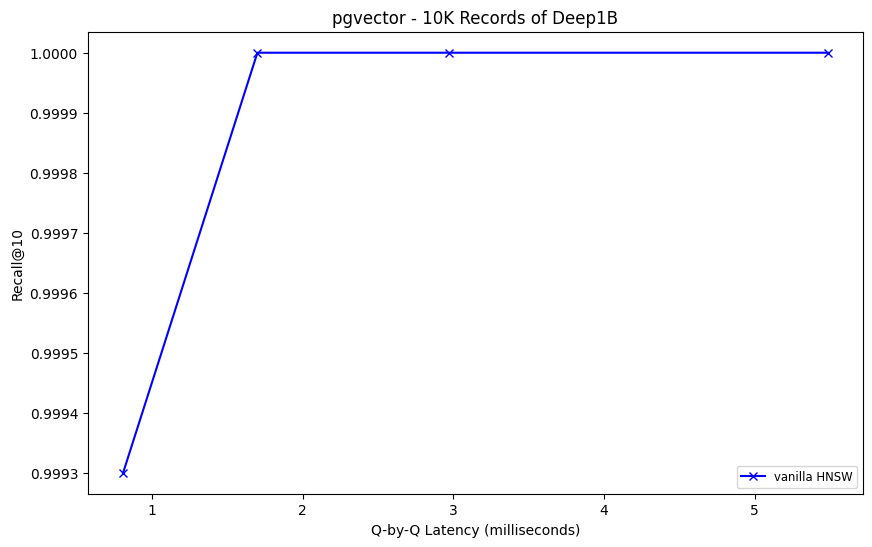

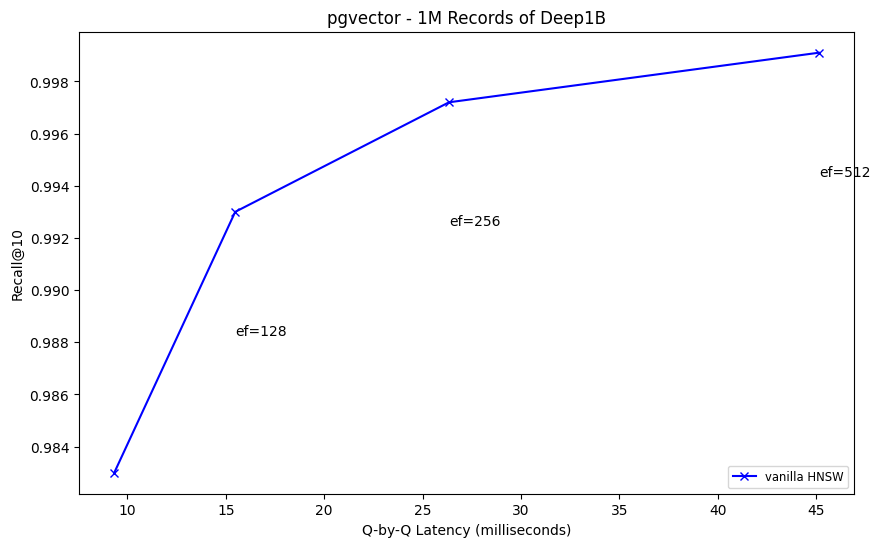

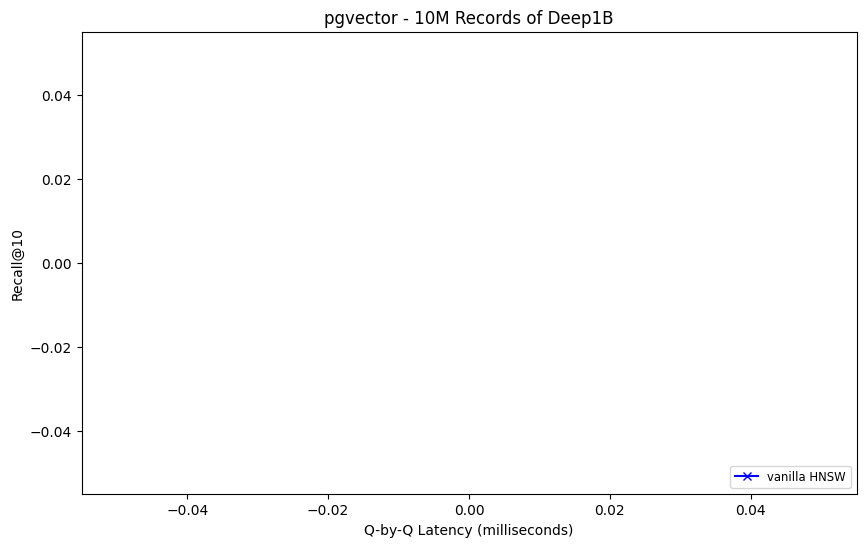

In [9]:
lst = ['10K', '1M', '10M']#, '20M', '50M', '100M', '250M', '500M', '1000M']
for i in lst:
    plot_paretto(i)

# Index Build Time

In [23]:
df = pgvector_df[['operation', 'walltime', 'dataset', 'numrecs', 'workers']] # seconds
df = df[df['operation'] == 'build']
df = df.sort_values(by=['numrecs'])
df

,operation,walltime,dataset,numrecs,workers
0,build,10.700061,deep-10K,10000,10
0,build,1990.584280,deep-1M,1000000,10
0,build,2141.176374,deep-1M,1000000,20
0,build,2027.361077,deep-1M,1000000,50
0,build,1928.130889,deep-1M,1000000,100


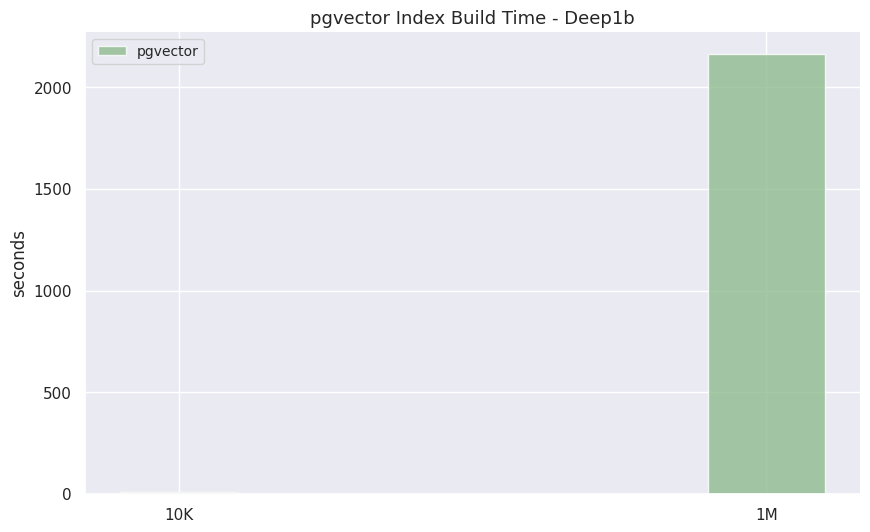

In [13]:
import seaborn as sns

# data

t = np.array(df.walltime.tolist())

# data sizes
sizes = ['10K', '1M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.2
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    
    pos = np.arange(len(t))

    fig, ax = plt.subplots()

    b = plt.bar(pos, t, bar_width, color='darkseagreen', label='pgvector', alpha=0.8)

    plt.xticks(pos, sizes)
    plt.ylabel('seconds')
    plt.legend(loc='upper left', fontsize=10)
    sns.despine()

    plt.title('pgvector Index Build Time - Deep1b', fontsize=13)

    plt.savefig('results/vis/pgvector_index_build_time_total.png', bbox_inches="tight")
    plt.show()